In [1]:
# Imports
%load_ext autoreload
%autoreload 2
from astropy.coordinates import Distance
import bilby
from gwBackground import *
import matplotlib.pyplot as plt
import numpy as np
from pygwb.constants import H0
H0_si = H0.si.value
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
import sys
sys.path.append('../code/')
from tqdm import tqdm

# Plot formatting
import matplotlib 
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
   matplotlib.rcParams[param] = params[param]    

In [3]:
# Calculate the merger rate
def R(alpha, beta, z, z_p, R0):
    '''
    Equation from Callister et al. 2020.
    Calculates the merger rate at a given redshift.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    z : double
        redshift
    z_p : double
        peak redshift of merger rate
    R0 : double
        current merger rate (z = 0)
        
    Returns
    -------
    double
        merger rate at the given redshift
    '''
    return (C(alpha, beta, z_p)*((R0*((1+z)**alpha))/(1+(((1+z)/(1+z_p))**(alpha+beta)))))

def C(alpha, beta, z_p):
    '''
    Equation from Callister et al. 2020.
    Calculates the normalization constant for the merger rate.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    z_p : double
        peak redshift of merger rate
    
    Returns
    -------
    double
        normalization constant for the merger rate
    '''
    return (1+((1+z_p)**(-alpha-beta)))

def Hubble_rate(z, H0, omega_R, omega_M, omega_k, omega_lambda):
    '''
    Equation from Renzini et al. 2022.
    Calculates the Hubble rate as a function of redshift.
    
    Parameters
    ----------
    z : double
        redshift
    H0 : double
        Hubble constant (Hubble rate at z = 0)
    omega_R : double
        radiation component of energy density
    omega_M : double
        matter component of energy density
    omega_k : double
        spacetime curvature component of energy density
    omega_lambda : double
        dark energy component of energy density, cosmological constant
    
    Returns
    -------
    double
        Hubble rate for a given redshift z
    '''
    return H0*(((omega_R*((1+z)**4))+(omega_M*((1+z)**3))+(omega_k*((1+z)**2))+omega_lambda)**(1/2))

alpha = 1.9 # R(z) \propto (1+z)^alpha for z <= z_p
beta = 3.4 # R(z) \propto (1+z)^-beta for z >= z_p
z_p = 2.4 # redshift at peak merger rate
z_max = 10 # maximum plausible redshift

H0 = 67.4 # Hubble constant (Hubble rate at z = 0)
omega_R = 9.182e-5 # radiation component of energy density
omega_M = 0.3111 # matter component of energy density
omega_k = 0 # spacetime curvature component of energy density
omega_lambda = 0.6889 # dark energy component of energy density, cosmological constant
R0 = 28.3 # current merger rate

dz = 0.01 # redshift bin step size
zsMerger = np.arange(0.,z_max,dz) # redshift bins

# Calculate R(z)
mergerRate = []
for i in range(len(zsMerger)):
    mergerRate.append(R(alpha, beta, zsMerger[i], z_p, R0))
mergerRate = np.array(mergerRate)

In [4]:
# Define redshift prior
from bilby.gw.prior import Cosmological
class PowerLawRedshiftPrior(Cosmological):
    def __init__(self, minimum, maximum, R0, alpha, beta, zp, **kwargs):
        self.R0 = R0
        self.alpha = alpha
        self.beta = beta
        self.zp = zp
        super(PowerLawRedshiftPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)
        
    def _get_redshift_arrays(self):
        zs = np.linspace(self._minimum['redshift'] * 0.99,
                         self._maximum['redshift'] * 1.01, 1000)
        C = 1 + (1 + self.zp)**(-self.alpha - self.beta)
        p_dz = (1/(1+zs)) * C * ((self.R0 * (1 + zs)**(self.alpha))/(1 + ((1 + zs)/(1 + self.zp))**(self.alpha + self.beta))) * 4 * np.pi * self.cosmology.differential_comoving_volume(zs).value
        
        return zs, p_dz
    
# Define priors for the parameters in the Regimbau method
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=5, maximum=50)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['theta_jn'] = bilby.core.prior.Uniform(0, 2*np.pi, name='theta_jn')
priors['redshift'] = PowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=z_p, name='redshift', minimum=0, maximum=10)

00:39 bilby INFO    : Using aligned spin prior
00:39 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [5]:
m1_min = 5.                         # Minimum BH mass
m1_max = 50.                        # Maximum BH mass
m2_min = 5.
m2_max = 50.
fmax = 3000.                        # Maximum frequency we want to consider
inspiralOnly=False                  # Include contributions from merger and ringdown
minimum_component_mass = m2_min
maximum_component_mass = m1_max
# omg = OmegaGW(minimum_component_mass,maximum_component_mass,zsMerger,fmax,inspiralOnly,
#         Mtots=np.logspace(np.log10(m1_min+m2_min),np.log10(m1_max+m2_max),40), 
#         qs=np.linspace(m2_min/m1_max,m2_max/m1_min,41))
omg = OmegaGW_BBH(minimum_component_mass,maximum_component_mass,zsMerger)

# Calculate probabilities based on the Regimbau method 
# Priors defined in (m1, q) space
probs = np.empty((omg.m1s_2d.shape[0],omg.qs_2d.shape[1])) # initialize array
for i in range(omg.m1s_2d.shape[0]): # for each m1
    for j in range(omg.qs_2d.shape[1]): # for each m2
        prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
        probs[i][j] = prob # insert probability into probability array
probs = probs*(omg.Mtots_2d/(1.+omg.qs_2d)) # multiply by the Jacobian

# Now make sure that we're specifying physical masses for our BH and NS components
probs[omg.m1s_2d<m1_min] = 0
probs[omg.m1s_2d>m1_max] = 0
probs[omg.m2s_2d<m2_min] = 0
probs[omg.m2s_2d>m2_max] = 0

# Finally, normalize the probabilities and give them to our OmegaGW calculator!
probs /= np.sum(probs)
omg.probs = probs

[ 10.          10.33933849  10.69019205  11.05295141
  11.4280206   11.81581733  12.21677349  12.63133564
  13.05996548  13.50314038  13.96135391  14.43511639
  14.92495545  15.43141664  15.955064    16.49648074
  17.05626983  17.63505472  18.23348001  18.85221217
  19.4919403   20.15337686  20.83725851  21.5443469
  22.27542952  23.03132059  23.81286195  24.62092401
  25.45640674  26.32024061  27.21338768  28.13684268
  29.09163406  30.07882518  31.0995155   32.15484177
  33.24597932  34.37414337  35.54059037  36.74661941
  37.99357365  39.28284185  40.61585988  41.99411235
  43.41913423  44.89251258  46.41588834  47.99095809
  49.61947603  51.30325585  53.0441728   54.84416576
  56.70523941  58.62946646  60.61898993  62.6760256
  64.8028644   67.00187504  69.27550656  71.62629116
  74.05684692  76.5698808   79.16819159  81.85467307
  84.63231721  87.5042175   90.47357242  93.54368899
  96.71798643 100.        ]
[0.1       0.1140625 0.128125  0.1421875 0.15625   0.1703125
 0.184375  0

/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_79070/402366436.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


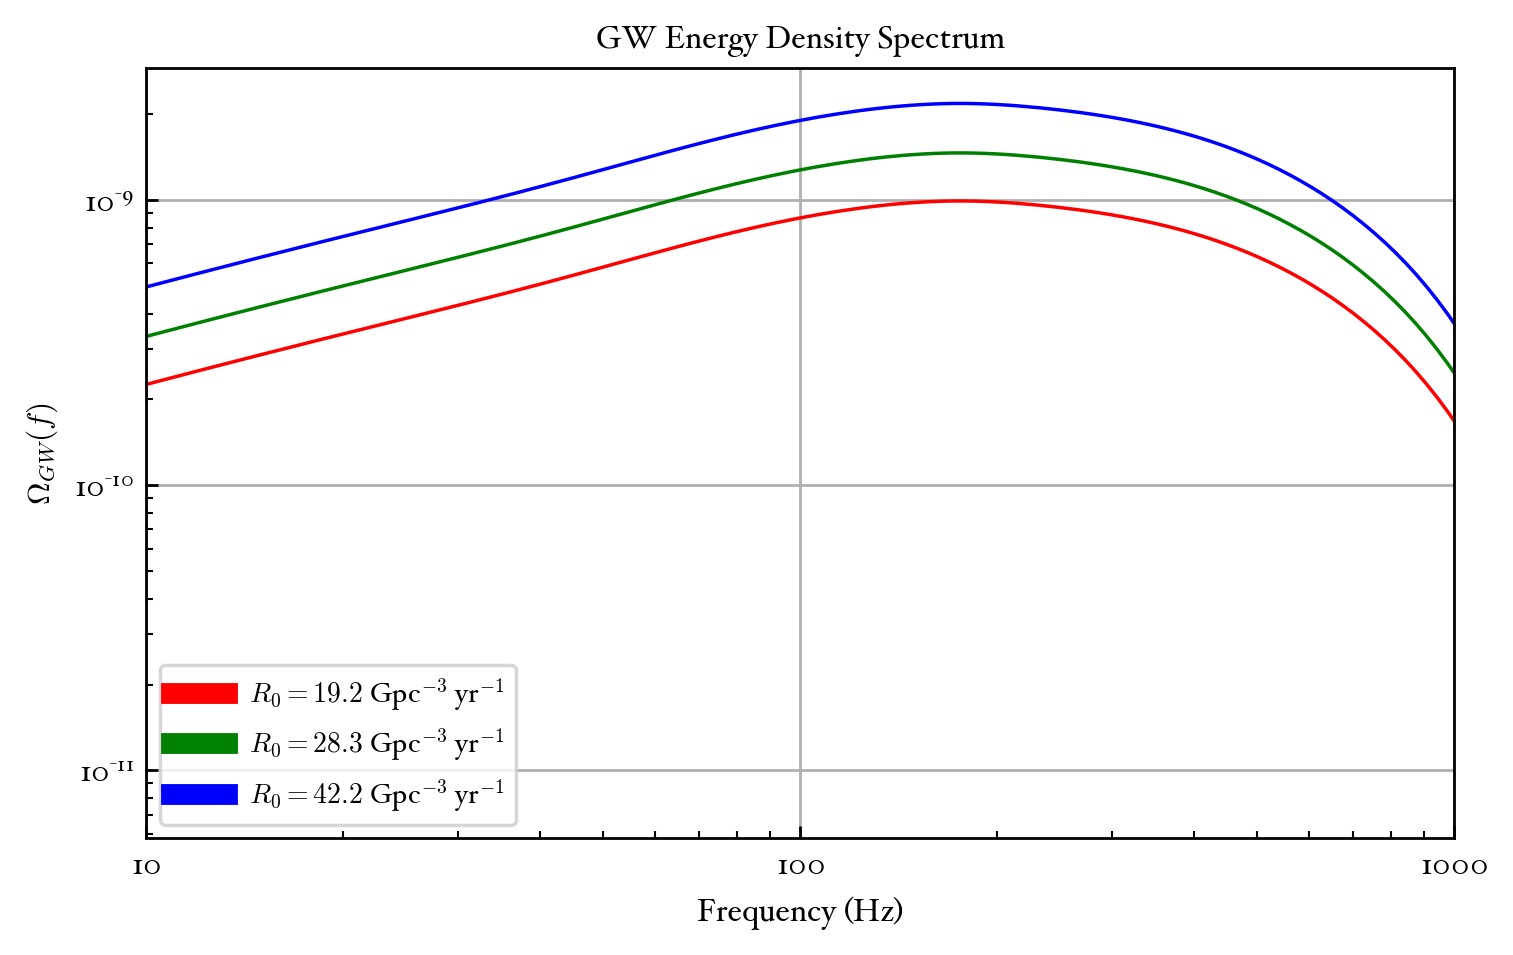

In [6]:
R_mean = 28.3
R_mean_min = 19.2
R_mean_max = 42.2

# Omega_GW vs. f for each R0
fig, ax = plt.subplots()
ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)

for i in [19.2,28.3,42.2]:
    R_mean = i
    freqs_TC = np.logspace(0,3.2,200)
    omega_f = omg.eval(R_mean,mergerRate,freqs_TC)
    if i == 19.2:
        ax.loglog(freqs_TC, omega_f, color='red', label=r'$R_0=19.2$ Gpc$^{-3}$ yr$^{-1}$')
    elif i == 42.2:
        ax.loglog(freqs_TC, omega_f, color='blue', label=r'$R_0=42.2$ Gpc$^{-3}$ yr$^{-1}$')
    else:
        ax.loglog(freqs_TC, omega_f, color='green', label=r'$R_0=28.3$ Gpc$^{-3}$ yr$^{-1}$')

ax.legend()
fig.show()